Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) $

if l2 norm append $\frac{\lambda}{2} \| w \|_2^2 $

if l1 norm append $\lambda \| w \|_1 $

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)}$

In [50]:
import numpy
# x: 1 by d
# w: d by 1
# y: scalar
# lam: scalar
# l1: boolean
# l2: boolean
def logistic_loss(x,w,y,lam,l1=False,l2=False):
    xw = numpy.dot(x,w) # scalar
    yxw = y * xw 
    error = numpy.log(1+numpy.exp(-yxw))
    if l2:
        norm = lam/2 * numpy.linalg.norm(w,ord=2) 
        error += norm 
    elif l1:
        norm = lam * numpy.linalg.norm(w,ord=1)
        error += norm
    return error[0,0]

In [22]:
# x: 1 by d
# w: d by 1
# y: scalar
# lam: scalar
# l1: boolean
# l2: boolean
def logistic_gradient(x,w,y,lam,l1=False,l2=False):
    yx = y * x
    yxw = numpy.dot(yx,w)
    denominator = 1 + numpy.exp(yxw)
    gradient = -1 * yx.T / denominator
    if l2:
        norm = 2 * lam * w
        gradient += norm
    elif l1:
        norm = lam * numpy.multiply(numpy.sign(w),w)
        gradient += norm
    return gradient

In [39]:
# X: n by d 
# y: n by 1
# lam: scalar
# stepsize: scalar
# max_epoch: scalar 
# w : d by 1
# gradient_function: 
# loss_function:
# proximal:
# l1: boolean
# l2: boolean
def saga(X,y,lam,stepsize,gradient_function,loss_function,proximal,max_epoch=100,w=None,l1=False,l2=False):
    n , d = X.shape
    if w == None:
        w = numpy.zeros((d,1))
        
    # initialize a table of gradients: n by d
    gradients = numpy.zeros((n,d))
    # fill in table with given weight
    for i in range(n):
        target = X[i].reshape((1,d))
        label = y[i]
        gradients[i] = gradient_function(target,w,label,lam,l1=l1,l2=l2).reshape(d)
        
    epoch_objs = []
        
    for epoch in range(max_epoch):
        # shuffle the entries
        perm = numpy.random.permutation(n)
        X_temp = X[perm] 
        y_temp = y[perm]
        
        obj_val = 0
        
        # for each epoch iterate through the set
        for i in range(n):
            target = X_temp[i].reshape((1,d))
            label = y_temp[i]
            gradient = gradient_function(target,w,label,lam,l1=l1,l2=l2)
            previous_gradient = gradients[perm[i]].reshape((d,1))
            gradients[perm[i]] = gradient.reshape(d)
            
            # update weight
            update = gradient - previous_gradient + numpy.mean(gradients,axis=0).reshape((d,1))
            w = w - stepsize * update
            w = proximal(w)
            
            # add the error
            obj_val += loss_function(target,w,label,lam,l1=l1,l2=l2)
            
        obj_val /= n
        print('Objective Value at epoch ' + str(epoch) + ' is ' + str(obj_val))
        epoch_objs.append(obj_val)
        
    return w,epoch_objs

In [40]:
import matplotlib.pyplot as plt

def graph(obj_vals,title,l1=False,l2=False):
    epochs = range(len(obj_vals))
    plt.plot(epochs, obj_vals)
    plt.xlabel('Epochs')
    plt.ylabel('Objective Value')
    if l1:
        title += ' L1 Norm'
    if l2: 
        title += ' L2 Norm'
    plt.title(title)
    plt.show()    

def graph_suboptimal(obj_vals,title,l1=False,l2=False,epochs=20):
    minimum = min(obj_vals)
    temp = obj_vals[:20] - minimum
    epochs = range(len(temp))
    plt.plot(epochs, temp)
    plt.xlabel('Epochs')
    plt.ylabel('Suboptimum')
    if l1:
        title += ' L1 Norm'
    if l2: 
        title += ' L2 Norm'
    plt.title(title)
    plt.show()

In [ ]:
# create new matrix with normalized rows
def normalize(matrix):
    ret = numpy.zeros(matrix.shape)
    for i in range(len(matrix)):
        vector = matrix[i]
        divisor = numpy.linalg.norm(vector)
        ret[i] = vector / divisor
    return ret

In [ ]:
# standardize by variance
def standardize(x_train,x_test):
    # calculate mu and sig using the training set
    d = x_train.shape[1]
    mu = numpy.mean(x_train, axis=0).reshape(1, d)
    sig = numpy.std(x_train, axis=0).reshape(1, d)

    # transform the training features
    x_train = (x_train - mu) / (sig + 1E-6)

    # transform the test features
    x_test = (x_test - mu) / (sig + 1E-6)

In [44]:
#https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        array = numpy.frombuffer(f.read(), dtype=numpy.uint8).reshape(shape)
        return array.copy()

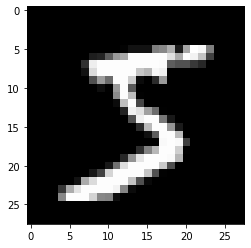

The testing label is 5


In [45]:
import matplotlib.pyplot as plt 

X_test = read_idx("mnist/t10k-images-idx3-ubyte")
y_test = read_idx("mnist/t10k-labels-idx1-ubyte")

X_train = read_idx("mnist/train-images-idx3-ubyte")
y_train = read_idx("mnist/train-labels-idx1-ubyte")


plt.imshow(X_train[0,:,:],cmap='gray')
plt.show()
print('The testing label is ' + str(y_train[0]))

y_train = numpy.array(list(map(lambda x:-1 if x < 5 else 1,y_train)))
y_test = numpy.array(list(map(lambda x:-1 if x <5 else 1, y_test)))


X_train = X_train[:1000,:,:]
y_train = y_train[:1000]
train_n,d,_ = X_train.shape
test_n,_,_ = X_test.shape

X_train = X_train.reshape((train_n,d*d))
X_test = X_test.reshape((test_n,d*d))


y_train = y_train.reshape((train_n,1))
y_test = y_test.reshape((test_n,1))

X_train = normalize(X_train)
X_test = normalize(X_test)

In [54]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(X_train,X_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(X_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
print('l1 start')
w_mnist_l1, obj_vals_mnist_l1 = saga(X_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l1=True,max_epoch=1000)
graph(obj_vals_mnist_l1,'Mnist',l1=True)
graph_suboptimal(obj_vals_mnist_l1,'Mnist',l1=True)
print('l2 start')
w_mnist_l2, obj_vals_mnist_l2 = saga(X_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l2=True,max_epoch=1000)
graph(obj_vals_mnist_l2,'Mnist',l2=True)
graph_suboptimal(obj_vals_mnist_l2,'Mnist',l2=True)

Objective Value at epoch 0 is 0.6793341953911012
Objective Value at epoch 1 is 0.6539089918588682
Objective Value at epoch 2 is 0.6332098048195541
Objective Value at epoch 3 is 0.6143825429767971
Objective Value at epoch 4 is 0.5990985587129019
Objective Value at epoch 5 is 0.585312081073896
Objective Value at epoch 6 is 0.5733376042021472
Objective Value at epoch 7 is 0.5623697530584482
Objective Value at epoch 8 is 0.5527152884646301
Objective Value at epoch 9 is 0.5443595988318681
Objective Value at epoch 10 is 0.5363558601340691
Objective Value at epoch 11 is 0.5292242168465112
Objective Value at epoch 12 is 0.5223793155057761
Objective Value at epoch 13 is 0.5162779277465817
Objective Value at epoch 14 is 0.5104331294164826
Objective Value at epoch 15 is 0.5050204357021895
Objective Value at epoch 16 is 0.5000319063643428
Objective Value at epoch 17 is 0.4952616492246849
Objective Value at epoch 18 is 0.49074374920982455
Objective Value at epoch 19 is 0.4866645541987464
Objective 

Objective Value at epoch 162 is 0.3452630385821579
Objective Value at epoch 163 is 0.3449493076981024
Objective Value at epoch 164 is 0.3446367499286332
Objective Value at epoch 165 is 0.34433464520068263
Objective Value at epoch 166 is 0.344017920335151
Objective Value at epoch 167 is 0.34370409971382904
Objective Value at epoch 168 is 0.34339857457893197
Objective Value at epoch 169 is 0.3431024687483433
Objective Value at epoch 170 is 0.3427951565289991
Objective Value at epoch 171 is 0.3425000251777285
Objective Value at epoch 172 is 0.3422059874376791
Objective Value at epoch 173 is 0.34192231634557857
Objective Value at epoch 174 is 0.341617874125182
Objective Value at epoch 175 is 0.3413301415230027
Objective Value at epoch 176 is 0.34103675581339266
Objective Value at epoch 177 is 0.34075529424372347
Objective Value at epoch 178 is 0.3404724657843041
Objective Value at epoch 179 is 0.34019818050262723
Objective Value at epoch 180 is 0.33990496547057897
Objective Value at epoch 

Objective Value at epoch 322 is 0.3109681977866657
Objective Value at epoch 323 is 0.31081745436403085
Objective Value at epoch 324 is 0.3106650778684262
Objective Value at epoch 325 is 0.31051482227053867
Objective Value at epoch 326 is 0.3103627928545483
Objective Value at epoch 327 is 0.3102112790817683
Objective Value at epoch 328 is 0.310062980571077
Objective Value at epoch 329 is 0.3099066110365336
Objective Value at epoch 330 is 0.3097533862428252
Objective Value at epoch 331 is 0.309610356129498
Objective Value at epoch 332 is 0.3094588488652746
Objective Value at epoch 333 is 0.309310676032659
Objective Value at epoch 334 is 0.30916181108099317
Objective Value at epoch 335 is 0.3090114397577764
Objective Value at epoch 336 is 0.3088615560367927
Objective Value at epoch 337 is 0.30872069615433734
Objective Value at epoch 338 is 0.30856771744468703
Objective Value at epoch 339 is 0.3084210364015685
Objective Value at epoch 340 is 0.30827711419425263
Objective Value at epoch 341

Objective Value at epoch 482 is 0.2908488460392904
Objective Value at epoch 483 is 0.2907470179157752
Objective Value at epoch 484 is 0.29064472266620284
Objective Value at epoch 485 is 0.29054025029303504
Objective Value at epoch 486 is 0.2904372819221421
Objective Value at epoch 487 is 0.2903279056754013
Objective Value at epoch 488 is 0.29022606114911487
Objective Value at epoch 489 is 0.29012417769787313
Objective Value at epoch 490 is 0.2900223855166432
Objective Value at epoch 491 is 0.28991966525495255
Objective Value at epoch 492 is 0.28981635013881435
Objective Value at epoch 493 is 0.28971862916849794
Objective Value at epoch 494 is 0.2896110216663067
Objective Value at epoch 495 is 0.2895093596597963
Objective Value at epoch 496 is 0.28940824215115235
Objective Value at epoch 497 is 0.2893042293637696
Objective Value at epoch 498 is 0.28920681180229274
Objective Value at epoch 499 is 0.28910288344021184
Objective Value at epoch 500 is 0.2890068718698862
Objective Value at ep

Objective Value at epoch 642 is 0.2763190516691643
Objective Value at epoch 643 is 0.27624235517341583
Objective Value at epoch 644 is 0.2761611655086814
Objective Value at epoch 645 is 0.276081720397313
Objective Value at epoch 646 is 0.27600257600009853
Objective Value at epoch 647 is 0.275923602357715
Objective Value at epoch 648 is 0.27584605629781417
Objective Value at epoch 649 is 0.27576760508296444
Objective Value at epoch 650 is 0.27568951035882744
Objective Value at epoch 651 is 0.2756103267267968
Objective Value at epoch 652 is 0.2755328777743573
Objective Value at epoch 653 is 0.27545318386417567
Objective Value at epoch 654 is 0.27537522843838375
Objective Value at epoch 655 is 0.2752950162219694
Objective Value at epoch 656 is 0.2752157409556452
Objective Value at epoch 657 is 0.2751416724301369
Objective Value at epoch 658 is 0.275063697499387
Objective Value at epoch 659 is 0.27498313477424335
Objective Value at epoch 660 is 0.2749088365927675
Objective Value at epoch 6

Objective Value at epoch 802 is 0.26491762781690525
Objective Value at epoch 803 is 0.264855785555205
Objective Value at epoch 804 is 0.26478879752424483
Objective Value at epoch 805 is 0.2647253262891334
Objective Value at epoch 806 is 0.2646618396382822
Objective Value at epoch 807 is 0.26459562268986137
Objective Value at epoch 808 is 0.26453280900232395
Objective Value at epoch 809 is 0.26447177481380324
Objective Value at epoch 810 is 0.26440426237058967
Objective Value at epoch 811 is 0.26434242991257023
Objective Value at epoch 812 is 0.26427793330712074
Objective Value at epoch 813 is 0.26421456060865023
Objective Value at epoch 814 is 0.2641517991213513
Objective Value at epoch 815 is 0.2640890519979422
Objective Value at epoch 816 is 0.2640256316908888
Objective Value at epoch 817 is 0.26396327372855866
Objective Value at epoch 818 is 0.2638986553154085
Objective Value at epoch 819 is 0.2638366295077524
Objective Value at epoch 820 is 0.2637736897576198
Objective Value at epo

Objective Value at epoch 962 is 0.25553446263641966
Objective Value at epoch 963 is 0.2554814062532052
Objective Value at epoch 964 is 0.2554260611468683
Objective Value at epoch 965 is 0.2553740478928542
Objective Value at epoch 966 is 0.25531974333026236
Objective Value at epoch 967 is 0.25526555393514067
Objective Value at epoch 968 is 0.2552113476807236
Objective Value at epoch 969 is 0.2551595049429016
Objective Value at epoch 970 is 0.25510587712839466
Objective Value at epoch 971 is 0.2550530086599428
Objective Value at epoch 972 is 0.2550003171467598
Objective Value at epoch 973 is 0.25494607086161575
Objective Value at epoch 974 is 0.2548932882331573
Objective Value at epoch 975 is 0.25483956770308974
Objective Value at epoch 976 is 0.2547873826289942
Objective Value at epoch 977 is 0.2547340478565574
Objective Value at epoch 978 is 0.25468084561115334
Objective Value at epoch 979 is 0.25462994500582264
Objective Value at epoch 980 is 0.25457653519995976
Objective Value at epo

In [56]:
from sklearn import datasets
import numpy

# dataset already scaled
x_sparse, y = datasets.load_svmlight_file('covtype.libsvm.binary.scale')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (581012, 54)
Shape of y: (581012,)


In [57]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 1000
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

Objective Value at epoch 0 is 0.22454173801501998
Objective Value at epoch 1 is 0.0483600389555013
Objective Value at epoch 2 is 0.034998854816386434
Objective Value at epoch 3 is 0.030524813862280783
Objective Value at epoch 4 is 0.027199680603092632
Objective Value at epoch 5 is 0.024603957123772034
Objective Value at epoch 6 is 0.022448224221541406
Objective Value at epoch 7 is 0.020660978376547647
Objective Value at epoch 8 is 0.019169676036377762
Objective Value at epoch 9 is 0.017858368920904828
Objective Value at epoch 10 is 0.016748501722421316
Objective Value at epoch 11 is 0.015772085639654723
Objective Value at epoch 12 is 0.014886493262856753
Objective Value at epoch 13 is 0.01411796169671252
Objective Value at epoch 14 is 0.013428831228522663
Objective Value at epoch 15 is 0.01279306049678407
Objective Value at epoch 16 is 0.012220426909036295
Objective Value at epoch 17 is 0.011708329690410482
Objective Value at epoch 18 is 0.011230865513788673
Objective Value at epoch 19

Objective Value at epoch 156 is 0.001781589597123354
Objective Value at epoch 157 is 0.0017711286620387165
Objective Value at epoch 158 is 0.0017605751887645347
Objective Value at epoch 159 is 0.0017503963848910964
Objective Value at epoch 160 is 0.001740288416576173
Objective Value at epoch 161 is 0.0017303156656356409
Objective Value at epoch 162 is 0.0017203331910750723
Objective Value at epoch 163 is 0.0017106750889496088
Objective Value at epoch 164 is 0.001700794103092322
Objective Value at epoch 165 is 0.0016916840763900206
Objective Value at epoch 166 is 0.0016817763234319653
Objective Value at epoch 167 is 0.0016723593435351218
Objective Value at epoch 168 is 0.0016631847824558953
Objective Value at epoch 169 is 0.001654130188149819
Objective Value at epoch 170 is 0.001645099463575209
Objective Value at epoch 171 is 0.0016361233582214412
Objective Value at epoch 172 is 0.001627375165032448
Objective Value at epoch 173 is 0.0016185207702942848
Objective Value at epoch 174 is 0.

Objective Value at epoch 309 is 0.0009410787543768762
Objective Value at epoch 310 is 0.0009381849325147645
Objective Value at epoch 311 is 0.0009354607275176682
Objective Value at epoch 312 is 0.0009325722557703555
Objective Value at epoch 313 is 0.0009297995939630587
Objective Value at epoch 314 is 0.00092700996485979
Objective Value at epoch 315 is 0.00092425213054066
Objective Value at epoch 316 is 0.0009214980154443599
Objective Value at epoch 317 is 0.0009187550156975797
Objective Value at epoch 318 is 0.000916121989190837
Objective Value at epoch 319 is 0.0009133387156377952
Objective Value at epoch 320 is 0.0009107090249089185
Objective Value at epoch 321 is 0.0009080366398924012
Objective Value at epoch 322 is 0.0009054061593504693
Objective Value at epoch 323 is 0.0009027679724637576
Objective Value at epoch 324 is 0.0009001579501109511
Objective Value at epoch 325 is 0.0008976023978377061
Objective Value at epoch 326 is 0.0008949071453106506
Objective Value at epoch 327 is 0

Objective Value at epoch 462 is 0.0006453237179152683
Objective Value at epoch 463 is 0.0006440213096826163
Objective Value at epoch 464 is 0.0006426982321520435
Objective Value at epoch 465 is 0.0006414196603231518
Objective Value at epoch 466 is 0.0006401514620890046
Objective Value at epoch 467 is 0.0006388647327289585
Objective Value at epoch 468 is 0.0006375682236895055
Objective Value at epoch 469 is 0.0006362905127982027
Objective Value at epoch 470 is 0.0006350348685250059
Objective Value at epoch 471 is 0.0006337900648667152
Objective Value at epoch 472 is 0.0006325429762117959
Objective Value at epoch 473 is 0.0006312550948294789
Objective Value at epoch 474 is 0.000630046553097589
Objective Value at epoch 475 is 0.0006287981159887101
Objective Value at epoch 476 is 0.0006275092383239791
Objective Value at epoch 477 is 0.000626274927961095
Objective Value at epoch 478 is 0.0006251045193537061
Objective Value at epoch 479 is 0.0006238702480045012
Objective Value at epoch 480 i

Objective Value at epoch 615 is 0.0004939907762359796
Objective Value at epoch 616 is 0.0004932817893948125
Objective Value at epoch 617 is 0.0004925307686594448
Objective Value at epoch 618 is 0.0004917738226394806
Objective Value at epoch 619 is 0.0004910552775308712
Objective Value at epoch 620 is 0.0004902956442430719
Objective Value at epoch 621 is 0.0004895647393177811
Objective Value at epoch 622 is 0.000488835602151318
Objective Value at epoch 623 is 0.0004881124608879039
Objective Value at epoch 624 is 0.00048737469458189975
Objective Value at epoch 625 is 0.00048665245527161356
Objective Value at epoch 626 is 0.0004859219566507795
Objective Value at epoch 627 is 0.0004852162879487141
Objective Value at epoch 628 is 0.00048449195125088186
Objective Value at epoch 629 is 0.000483770040319658
Objective Value at epoch 630 is 0.0004830602726222773
Objective Value at epoch 631 is 0.0004823672427101109
Objective Value at epoch 632 is 0.0004816462867292603
Objective Value at epoch 63

Objective Value at epoch 768 is 0.0004020311198814989
Objective Value at epoch 769 is 0.0004015602966996001
Objective Value at epoch 770 is 0.00040106409715812233
Objective Value at epoch 771 is 0.0004005796465028445
Objective Value at epoch 772 is 0.0004001018460448763
Objective Value at epoch 773 is 0.00039963339706350977
Objective Value at epoch 774 is 0.0003991540822104228
Objective Value at epoch 775 is 0.00039868049103939615
Objective Value at epoch 776 is 0.00039820457637997287
Objective Value at epoch 777 is 0.00039772941610573606
Objective Value at epoch 778 is 0.0003972579311435741
Objective Value at epoch 779 is 0.00039678825352349123
Objective Value at epoch 780 is 0.0003963175207225816
Objective Value at epoch 781 is 0.00039585870621809346
Objective Value at epoch 782 is 0.00039538962885572705
Objective Value at epoch 783 is 0.0003949201426348706
Objective Value at epoch 784 is 0.0003944524028668139
Objective Value at epoch 785 is 0.0003939775393022658
Objective Value at e

Objective Value at epoch 921 is 0.0003401802949685107
Objective Value at epoch 922 is 0.0003398422768989204
Objective Value at epoch 923 is 0.0003394969069139753
Objective Value at epoch 924 is 0.00033916802001311523
Objective Value at epoch 925 is 0.0003388186126693527
Objective Value at epoch 926 is 0.0003385016771509274
Objective Value at epoch 927 is 0.00033816756215474864
Objective Value at epoch 928 is 0.0003378388967474274
Objective Value at epoch 929 is 0.0003374965273075823
Objective Value at epoch 930 is 0.00033715989848127567
Objective Value at epoch 931 is 0.0003368333370431487
Objective Value at epoch 932 is 0.0003365033247580178
Objective Value at epoch 933 is 0.00033617722623363984
Objective Value at epoch 934 is 0.0003358465223693218
Objective Value at epoch 935 is 0.000335525633734201
Objective Value at epoch 936 is 0.0003351859248427518
Objective Value at epoch 937 is 0.0003348620015297677
Objective Value at epoch 938 is 0.00033453030531844054
Objective Value at epoch

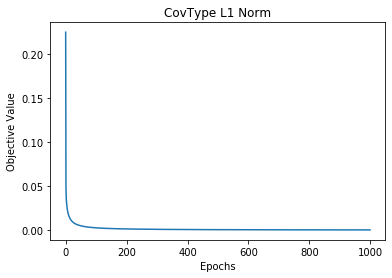

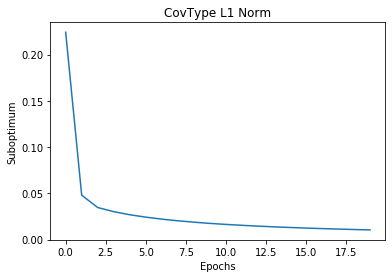

Objective Value at epoch 0 is 0.22534882183353727
Objective Value at epoch 1 is 0.048351511356060556
Objective Value at epoch 2 is 0.034984262703752565
Objective Value at epoch 3 is 0.030471369293206246
Objective Value at epoch 4 is 0.02717090632340012
Objective Value at epoch 5 is 0.02451551279740263
Objective Value at epoch 6 is 0.022383978377944855
Objective Value at epoch 7 is 0.020651877973314896
Objective Value at epoch 8 is 0.019144584409443874
Objective Value at epoch 9 is 0.017853408537700333
Objective Value at epoch 10 is 0.016732934668444135
Objective Value at epoch 11 is 0.0157571018349277
Objective Value at epoch 12 is 0.014879759308165019
Objective Value at epoch 13 is 0.014114566410446857
Objective Value at epoch 14 is 0.01341502010178393
Objective Value at epoch 15 is 0.012779681132855419
Objective Value at epoch 16 is 0.012214296959796473
Objective Value at epoch 17 is 0.011696087844918724
Objective Value at epoch 18 is 0.011213575911826746
Objective Value at epoch 19 

Objective Value at epoch 156 is 0.0017712270295716797
Objective Value at epoch 157 is 0.0017607839890204798
Objective Value at epoch 158 is 0.0017504376288031756
Objective Value at epoch 159 is 0.0017399817116313609
Objective Value at epoch 160 is 0.0017300448183753452
Objective Value at epoch 161 is 0.001719978914906672
Objective Value at epoch 162 is 0.0017098737380071036
Objective Value at epoch 163 is 0.0017002850375183601
Objective Value at epoch 164 is 0.0016905705689800009
Objective Value at epoch 165 is 0.0016809923896013723
Objective Value at epoch 166 is 0.001671598265436224
Objective Value at epoch 167 is 0.0016622171842089384
Objective Value at epoch 168 is 0.001652851266213335
Objective Value at epoch 169 is 0.0016435791032738823
Objective Value at epoch 170 is 0.001634470519645032
Objective Value at epoch 171 is 0.0016257848730668112
Objective Value at epoch 172 is 0.001616873921043359
Objective Value at epoch 173 is 0.0016080681502393722
Objective Value at epoch 174 is 0

Objective Value at epoch 310 is 0.00092686066413549
Objective Value at epoch 311 is 0.0009240486368438718
Objective Value at epoch 312 is 0.0009210971568631842
Objective Value at epoch 313 is 0.0009184145498396614
Objective Value at epoch 314 is 0.0009156315063931344
Objective Value at epoch 315 is 0.0009128871355905282
Objective Value at epoch 316 is 0.0009101029938161245
Objective Value at epoch 317 is 0.000907340436921777
Objective Value at epoch 318 is 0.0009046854238038411
Objective Value at epoch 319 is 0.0009019020862883522
Objective Value at epoch 320 is 0.0008992690285819796
Objective Value at epoch 321 is 0.000896661639996508
Objective Value at epoch 322 is 0.0008940076564306229
Objective Value at epoch 323 is 0.0008913661022832812
Objective Value at epoch 324 is 0.0008887368297844605
Objective Value at epoch 325 is 0.0008860944040305799
Objective Value at epoch 326 is 0.0008835142943326642
Objective Value at epoch 327 is 0.0008809720645254238
Objective Value at epoch 328 is 

Objective Value at epoch 464 is 0.0006306534191427935
Objective Value at epoch 465 is 0.0006293297891981488
Objective Value at epoch 466 is 0.0006280530961192284
Objective Value at epoch 467 is 0.0006267722198874761
Objective Value at epoch 468 is 0.0006255100597181803
Objective Value at epoch 469 is 0.0006242032612713057
Objective Value at epoch 470 is 0.0006229487258414111
Objective Value at epoch 471 is 0.0006216916364077691
Objective Value at epoch 472 is 0.0006204173121504678
Objective Value at epoch 473 is 0.000619159889420115
Objective Value at epoch 474 is 0.0006179238504092938
Objective Value at epoch 475 is 0.000616680460905714
Objective Value at epoch 476 is 0.0006154223274038911
Objective Value at epoch 477 is 0.0006142028280966019
Objective Value at epoch 478 is 0.000612981213000231
Objective Value at epoch 479 is 0.0006117204684666914
Objective Value at epoch 480 is 0.0006105053989319347
Objective Value at epoch 481 is 0.0006093175880461022
Objective Value at epoch 482 is

Objective Value at epoch 616 is 0.00048071267739617057
Objective Value at epoch 617 is 0.00047997442831118256
Objective Value at epoch 618 is 0.00047920336154011494
Objective Value at epoch 619 is 0.00047848068378449017
Objective Value at epoch 620 is 0.00047773892241789197
Objective Value at epoch 621 is 0.00047699393537274523
Objective Value at epoch 622 is 0.00047625349496856385
Objective Value at epoch 623 is 0.0004755043240605357
Objective Value at epoch 624 is 0.00047481097772531666
Objective Value at epoch 625 is 0.0004740782403795288
Objective Value at epoch 626 is 0.0004733189167446975
Objective Value at epoch 627 is 0.0004726219246304362
Objective Value at epoch 628 is 0.00047189261910087827
Objective Value at epoch 629 is 0.0004711666000666343
Objective Value at epoch 630 is 0.00047045034901253325
Objective Value at epoch 631 is 0.0004697370215073333
Objective Value at epoch 632 is 0.0004690363905040464
Objective Value at epoch 633 is 0.000468324105521124
Objective Value at 

Objective Value at epoch 768 is 0.00038907472987306297
Objective Value at epoch 769 is 0.000388594600331282
Objective Value at epoch 770 is 0.00038811989375878793
Objective Value at epoch 771 is 0.0003876221579610195
Objective Value at epoch 772 is 0.0003871427131531494
Objective Value at epoch 773 is 0.00038665737227139513
Objective Value at epoch 774 is 0.00038616072785057015
Objective Value at epoch 775 is 0.0003857045985052841
Objective Value at epoch 776 is 0.0003852204032138473
Objective Value at epoch 777 is 0.0003847564157907316
Objective Value at epoch 778 is 0.0003842646295682367
Objective Value at epoch 779 is 0.0003837958359365591
Objective Value at epoch 780 is 0.0003833414338732492
Objective Value at epoch 781 is 0.0003828592853341759
Objective Value at epoch 782 is 0.0003823898248119587
Objective Value at epoch 783 is 0.000381936398013851
Objective Value at epoch 784 is 0.00038146266020973085
Objective Value at epoch 785 is 0.0003809914326322859
Objective Value at epoch 

Objective Value at epoch 920 is 0.0003272387289933151
Objective Value at epoch 921 is 0.0003268952701929571
Objective Value at epoch 922 is 0.000326566520354808
Objective Value at epoch 923 is 0.0003262224319713427
Objective Value at epoch 924 is 0.0003258843168963634
Objective Value at epoch 925 is 0.0003255518348955234
Objective Value at epoch 926 is 0.0003251961225271348
Objective Value at epoch 927 is 0.0003248696384850213
Objective Value at epoch 928 is 0.00032452756918427547
Objective Value at epoch 929 is 0.00032420499361157055
Objective Value at epoch 930 is 0.00032386310004866035
Objective Value at epoch 931 is 0.000323535028567336
Objective Value at epoch 932 is 0.00032320319806722683
Objective Value at epoch 933 is 0.0003228665682170516
Objective Value at epoch 934 is 0.000322542771828896
Objective Value at epoch 935 is 0.00032220294721691753
Objective Value at epoch 936 is 0.0003218865941957363
Objective Value at epoch 937 is 0.00032155373387991835
Objective Value at epoch 

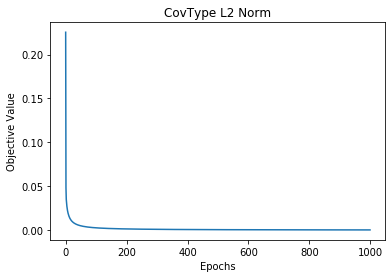

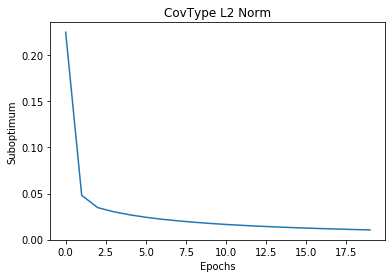

In [58]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(x_train,x_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(x_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
print('l1 start')
w_cov_l1, obj_vals_cov_l1 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l1=True,max_epoch=100)
graph(obj_vals_cov_l1,'CovType',l1=True)
graph_suboptimal(obj_vals_cov_l1,'CovType',l1=True)
print('l2 start')
w_cov_l2, obj_vals_cov_l2 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l2=True,max_epoch=100)
graph(obj_vals_cov_l2,'CovType',l2=True)
graph_suboptimal(obj_vals_cov_l2,'CovType',l2=True)

In [59]:
from sklearn import datasets
import numpy

# dataset already scaled
x_sparse, y = datasets.load_svmlight_file('ijcnn1.tr')
x = x_sparse.todense()

rand_indices = numpy.random.permutation(n)
x = x[rand_indices]
y = y[rand_indices]

x_train = x[:1000]
y_train = y[:1000]

l1 start
Objective Value at epoch 0 is 0.4609935541488817
Objective Value at epoch 1 is 0.3003318680914656
Objective Value at epoch 2 is 0.28423983913198864
Objective Value at epoch 3 is 0.2815333487220443
Objective Value at epoch 4 is 0.2799435584267859
Objective Value at epoch 5 is 0.2792952649258912
Objective Value at epoch 6 is 0.27878771596603097
Objective Value at epoch 7 is 0.27831909436751057
Objective Value at epoch 8 is 0.27780223861154235
Objective Value at epoch 9 is 0.2773071879118055
Objective Value at epoch 10 is 0.2769186210337217
Objective Value at epoch 11 is 0.27649620880286907
Objective Value at epoch 12 is 0.2761187620569454
Objective Value at epoch 13 is 0.27575342240198514
Objective Value at epoch 14 is 0.27541409231764735
Objective Value at epoch 15 is 0.2750342266319165
Objective Value at epoch 16 is 0.27466998693163486
Objective Value at epoch 17 is 0.27430052393711063
Objective Value at epoch 18 is 0.2740431004505242
Objective Value at epoch 19 is 0.273708208

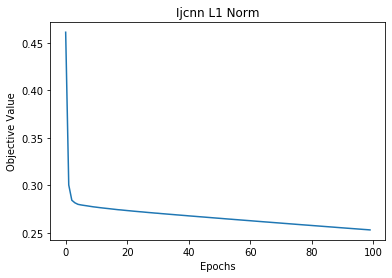

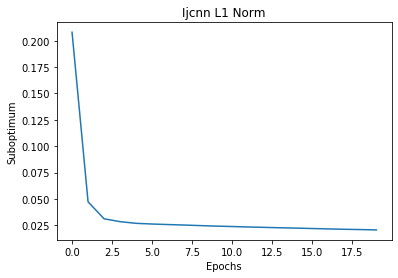

l2 start
Objective Value at epoch 0 is 0.46426942172611213
Objective Value at epoch 1 is 0.3032394041354065
Objective Value at epoch 2 is 0.28391794431659906
Objective Value at epoch 3 is 0.2811814125206746
Objective Value at epoch 4 is 0.2803307471365051
Objective Value at epoch 5 is 0.2794251317232412
Objective Value at epoch 6 is 0.27867956934096677
Objective Value at epoch 7 is 0.27826246686222783
Objective Value at epoch 8 is 0.2777610407839225
Objective Value at epoch 9 is 0.27737694917409944
Objective Value at epoch 10 is 0.27688672793389735
Objective Value at epoch 11 is 0.2764769665493806
Objective Value at epoch 12 is 0.2761198965896524
Objective Value at epoch 13 is 0.2757182438068049
Objective Value at epoch 14 is 0.2754165744762911
Objective Value at epoch 15 is 0.2750402531630317
Objective Value at epoch 16 is 0.27470398465931806
Objective Value at epoch 17 is 0.27433766148395333
Objective Value at epoch 18 is 0.2740072343579094
Objective Value at epoch 19 is 0.2737035871

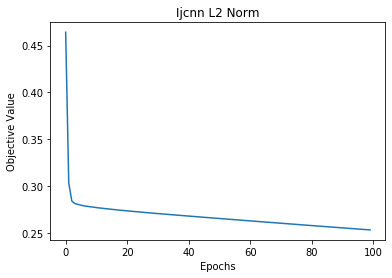

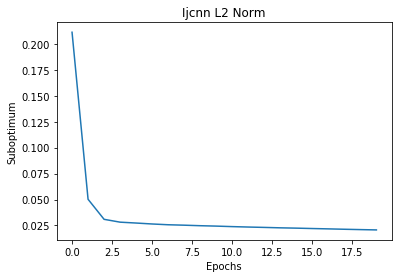

In [60]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(x_train,x_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(x_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
print('l1 start')
w_cov_l1, obj_vals_ijcnn_l1 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l1=True,max_epoch=100)
graph(obj_vals_ijcnn_l1,'Ijcnn',l1=True)
graph_suboptimal(obj_vals_ijcnn_l1,'Ijcnn',l1=True)
print('l2 start')
w_cov_l2, obj_vals_ijcnn_l2 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l2=True,max_epoch=100)
graph(obj_vals_ijcnn_l2,'Ijcnn',l2=True)
graph_suboptimal(obj_vals_ijcnn_l2,'Ijcnn',l2=True)